## Predicting Scoring Patterns based on Song Order: Eurovision 2021

In [1]:
import numpy as np
import pandas as pd

If we used Python to read the html_file, we would use the following code:
```
from pandas import read_html
test = pd.read_html("html database/Eurovision Song Contest Database 2021.html")[1]
```

We would take the second element `[1]` here, because `[0]` is the initial text outside of the table.<p><p>

### Importing the Data
Instead of using `read_html` on the html file, we are going to take the newly formed csv file made in R / SQL, and make that the `test` database:

In [2]:
# The year we are analyzing
year = 2021

# Let's make it a function in case re-use the methods for a different year:
def create_df(year):

    # Instead, we are going to simply read the .csv created using R and SQL:
    test = pd.read_csv("csv database/%s Eurovision Final Results.csv" % year)

    # Replace the duplicate index column with the year of the contest:
    test = test.rename({"Unnamed: 0":"Year"}, axis=1)
    test['Year'] = year
    
    # Sort the rows by song order and reset the indicies:
    test = test.sort_values(by="Song_Order").reset_index(drop=True)
    
    # Let's show a short preview of the data here:
    print(test.head())
    return test

# First, let's apply this function to 2021:
test = create_df(year)

   Year  Place  Points  Percent_Earned  Song_Order  Country  Participants
0  2021     16      94        0.103070           1   Cyprus            39
1  2021     21      57        0.062500           2  Albania            39
2  2021     17      93        0.101974           3   Israel            39
3  2021     19      74        0.081140           4  Belgium            39
4  2021      9     204        0.223684           5   Russia            39


### Visualizing the Data

Now, we can import the following packages to help visualize the data and its' regression models:

In [3]:
# Jupyter Notebook is weird, and requires this code to show all graphs when running the entire code at once.
%matplotlib inline

# Now, let's import matplotlib and seaborn for visualizations. seaborn specializes in regression.
import matplotlib.pyplot as plt
import seaborn as sb

# We need the following package to summarize the linear regression:
from statsmodels.formula.api import ols

Let's take the percent of points earned (`Percent_Earned`), and fit it based on the order of songs (`Song_Order`). We will view the graph without and with the linear regression line side-by-side:

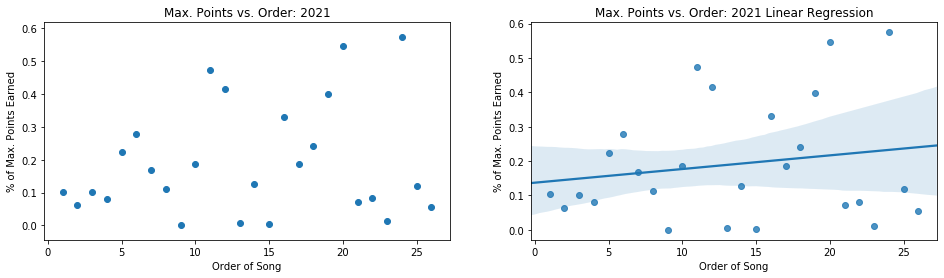

In [4]:
def graph_scatter(test, x, y, xlab, ylab, title):
    points_lm = ols('%s ~ %s' % (y, x), data=test).fit()

    # Plotting the scatter plot without and with the regression line side-by-side:
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,4))

    ax1.scatter(x, y, data=test)
    ax1.set_xlabel(xlab)
    ax1.set_ylabel(ylab)
    ax1.set_title("%s: %s" % (title, year))

    sb.regplot(x, y, data=test)
    ax2.set_xlabel(xlab)
    ax2.set_ylabel(ylab)
    ax2.set_title("%s: %s Linear Regression" % (title, year))

    plt.show()

# Let's apply this table, making percent of points earned (Percent_Earned) our response (y), and song order
# (Song_Order) our predictor (x):
graph_scatter(test, 'Song_Order', 'Percent_Earned',
                    'Order of Song', '% of Max. Points Earned', "Max. Points vs. Order")

There does not appear to be a significant correlation, according to the second graph and its linear regression formula. Let's confirm that hypothesis by fitting the data to an Ordinary Least Squares (OLS) regression model:

In [5]:
def fit_and_desc_ols(test, x, y):
    ols_lm = ols('%s ~ %s' % (y,x), data=test).fit()
    
    print("Eurovision", year)
    print(ols_lm.summary())

# Let's summarize the data using the OLS Regression Model on our aforementioned data:
fit_and_desc_ols(test, 'Song_Order', 'Percent_Earned')

Eurovision 2021
                            OLS Regression Results                            
Dep. Variable:         Percent_Earned   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.7938
Date:                Wed, 22 Sep 2021   Prob (F-statistic):              0.382
Time:                        00:29:39   Log-Likelihood:                 10.143
No. Observations:                  26   AIC:                            -16.29
Df Residuals:                      24   BIC:                            -13.77
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1372      0.069    

With a p-value of $0.382$, it appears that song order and point percentage hardly have any linear correlation. Even with the `Song_Order` coefficient, there is only a slight positive correlation of `0.0039`. It seems like the song order does not sway the percent of points earned in either direction.
<p>
<p>However, if we look at the graph again, we can tell that there's a lot more divergence in the points as song order increases. In other words, the points earned get less and less predictable as a song is placed later in the order. This time, let's take residuals from each point, and compare their magnitude (absolute value) to their respective song order:

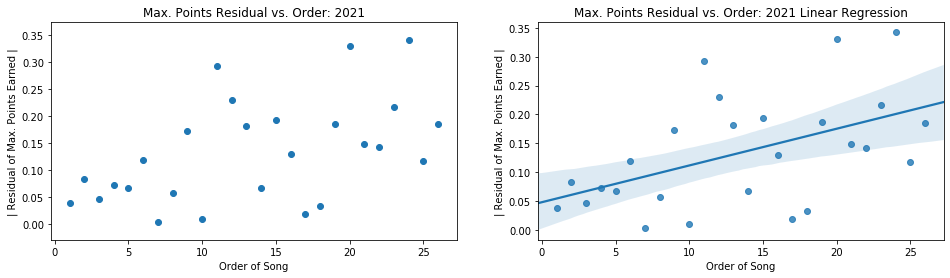

In [6]:
# Magnitude of Residuals:
def add_mag_residual(test, x, y, res_lab):
    ols_lm = ols('%s ~ %s' % (y,x), data=test).fit()
    
    test['%s' % res_lab] = abs(ols_lm.resid)
    return test

# Magnitude of Residuals from Percentage of Max. Points Earned (Percent_Earned):
test = add_mag_residual(test, 'Song_Order', 'Percent_Earned', res_lab='Perc_Mag_Res')

# Now, we can apply the same graphing function, making the residual (Res_Abs) our response (y), and
# keeping song order (Song_Order) as our predictor (x):
graph_scatter(test, 'Song_Order', 'Perc_Mag_Res',
                    'Order of Song', '| Residual of Max. Points Earned |', "Max. Points Residual vs. Order")

The residuals appear to have a more direct linear trend with the song order. Based on the graph on the right, it appears that as songs go later in the order, their predictability becomes less accurate. This could imply that voters are more sporadic with how they vote as they listen to more songs.
<p>
<p>Let's make sure that this prediction is significant within the data:

In [7]:
# Now, let's summarize regression model between residual and song order:
fit_and_desc_ols(test, 'Song_Order', 'Perc_Mag_Res')

Eurovision 2021
                            OLS Regression Results                            
Dep. Variable:           Perc_Mag_Res   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     8.249
Date:                Wed, 22 Sep 2021   Prob (F-statistic):            0.00839
Time:                        00:29:40   Log-Likelihood:                 28.333
No. Observations:                  26   AIC:                            -52.67
Df Residuals:                      24   BIC:                            -50.15
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0480      0.034    

It looks like we have a trend! Since the song order's p-value ($0.008$) is less than 0.01, we can say with 99% confidence that song order positively correlates with how points are distributed. This proves that later songs have a more volatile chance at earning higher and lower results, compared to their earlier counterparts.

### Deviation and Placing

Another interesting note is that the closer a song is to the middle of the pack place-wise (i.e. somewhere around 13th place), their residual shrinks and the opposite as the song's place is further from the middle. This implies very high and low placed songs tend to occur later in the contest, rather than earlier.

In [8]:
ols_lm = ols('Percent_Earned ~ Song_Order', data=test).fit()
test['Fitted'] = ols_lm.fittedvalues

test[['Place','Percent_Earned','Fitted','Perc_Mag_Res']].iloc[8:10+1,:]

,Place,Percent_Earned,Fitted,Perc_Mag_Res
8,26,0.000000,0.172915,0.172915
9,10,0.186404,0.176887,0.009516
10,3,0.473684,0.180859,0.292825


## Is this a fluke?

Can we apply the same idea to previous contest years? Let's try it out!

In [9]:
year = 2019
test2019 = create_df(year)

   Year  Place  Points  Percent_Earned  Song_Order         Country  \
0  2019     14     107        0.111458           1           Malta   
1  2019     17      90        0.093750           2         Albania   
2  2019     11     157        0.163542           3  Czech Republic   
3  2019     25      24        0.025000           4         Germany   
4  2019      3     370        0.385417           5          Russia   

   Participants  
0            41  
1            41  
2            41  
3            41  
4            41  


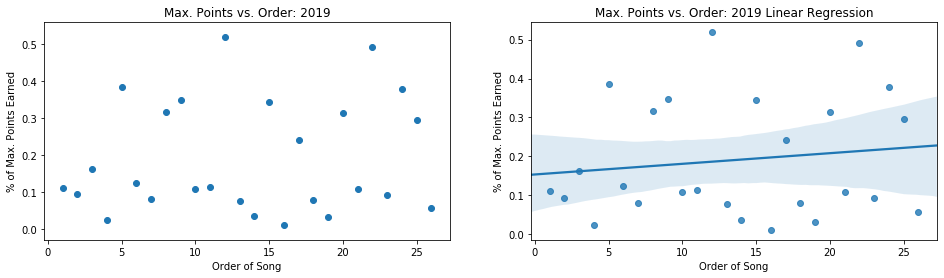

Eurovision 2019
                            OLS Regression Results                            
Dep. Variable:         Percent_Earned   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                    0.4619
Date:                Wed, 22 Sep 2021   Prob (F-statistic):              0.503
Time:                        00:29:40   Log-Likelihood:                 12.818
No. Observations:                  26   AIC:                            -21.64
Df Residuals:                      24   BIC:                            -19.12
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1536      0.062    

In [10]:
graph_scatter(test2019, 'Song_Order', 'Percent_Earned',
                    'Order of Song', '% of Max. Points Earned', "Max. Points vs. Order")

fit_and_desc_ols(test2019, 'Song_Order', 'Percent_Earned')

It seems like it is a similar case for the 2019 entries. Let's try the residual method again, and see if this year also has unpredictability as song order increases:

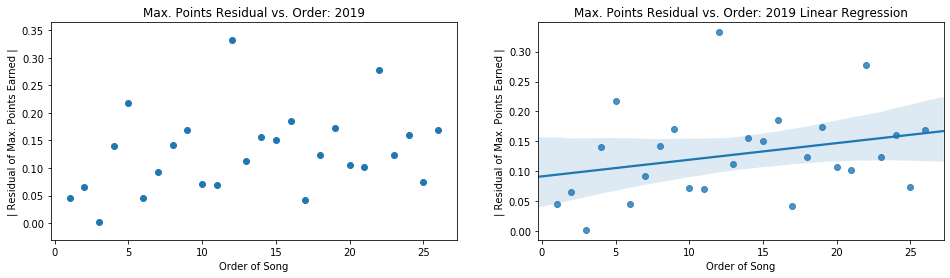

Eurovision 2019
                            OLS Regression Results                            
Dep. Variable:           Perc_Mag_Res   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     2.166
Date:                Wed, 22 Sep 2021   Prob (F-statistic):              0.154
Time:                        00:29:41   Log-Likelihood:                 32.428
No. Observations:                  26   AIC:                            -60.86
Df Residuals:                      24   BIC:                            -58.34
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0912      0.029    

In [11]:
test2019 = add_mag_residual(test2019, 'Song_Order', 'Percent_Earned', res_lab='Perc_Mag_Res')

graph_scatter(test2019, 'Song_Order', 'Perc_Mag_Res',
                    'Order of Song', '| Residual of Max. Points Earned |', "Max. Points Residual vs. Order")

fit_and_desc_ols(test2019, 'Song_Order', 'Perc_Mag_Res')

It seems like a few outliers are skewing the data's correlation, but other than that, there seems to be a trending positive pattern. Let's remove the three greatest outliers from the 2019 data.

In [12]:
ols_lm = ols('Perc_Mag_Res ~ Song_Order', data=test2019).fit()

# Drop the three points with the highest residuals from the residual regression
res_vals = abs(ols_lm.resid)
n = 3

test2019a = test2019.drop( res_vals.nlargest(n).index )

# 3 biggest outliers:
print( test2019.loc[res_vals.nlargest(n).index,['Song_Order','Country','Place','Points','Percent_Earned','Perc_Mag_Res']] )

    Song_Order      Country  Place  Points  Percent_Earned  Perc_Mag_Res
11          12  Netherlands      1     498        0.518750      0.332306
21          22        Italy      2     472        0.491667      0.277886
4            5       Russia      3     370        0.385417      0.218108


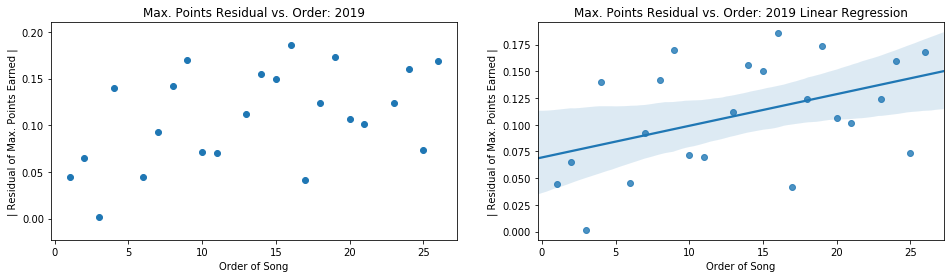

Eurovision 2019
                            OLS Regression Results                            
Dep. Variable:           Perc_Mag_Res   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     5.357
Date:                Wed, 22 Sep 2021   Prob (F-statistic):             0.0308
Time:                        00:29:41   Log-Likelihood:                 39.016
No. Observations:                  23   AIC:                            -74.03
Df Residuals:                      21   BIC:                            -71.76
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0693      0.020    

In [13]:
graph_scatter(test2019a, 'Song_Order', 'Perc_Mag_Res',
                    'Order of Song', '| Residual of Max. Points Earned |', "Max. Points Residual vs. Order")

fit_and_desc_ols(test2019a, 'Song_Order', 'Perc_Mag_Res')